In [3]:
# Import necessary libraries
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from model.maxsr_tiny import MaxSRTiny
from model.maxsr_super_tiny import MaxSRSuperTiny
from model_evaluation.metrics import calculate_psnr_ssim_metrics
from utils.utils import load_config, load_image
from utils.plotting import tensor_to_RGB_image
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Images for inefrence

In [4]:
images = ['21.jpeg', '23.jpeg', '35.jpeg', '64.jpeg', '83.jpeg']

In [5]:
# Load the images
lr_image_path = '/home/linuxu/Documents/datasets/Tiny_LR/'  
hr_image_path = '/home/linuxu/Documents/datasets/Tiny_HR/'  

lr_images = [lr_image_path + image for image in images]
hr_images = [hr_image_path + image for image in images]

In [14]:
single_images_path = '/home/linuxu/Documents/results-visual/singles'

for base in ['lr', 'hr', 'super-tiny', 'tiny']:
    os.makedirs(f'{single_images_path}/{base}')

In [49]:
def plot_image_with_footer(im_src: str, title: str, footer: str, output_path: str):
    im = Image.open(im_src) if isinstance(im_src, str) else im_src
    
    fig = plt.figure()

    # Plot Low Resolution Image
    ax = fig.add_subplot()
    plt.imshow(im)
    plt.title(title)
    plt.axis('off')
    ax.text(0.5, -0.1, footer, ha='center', fontsize=10, transform=ax.transAxes)

    plt.savefig(f'{single_images_path}/{output_path}', dpi=300, bbox_inches='tight')
    plt.close()
    

# Print Everything as single images

In [50]:
for i, lr in enumerate(lr_images):
    plot_image_with_footer(lr, title='Low Resolution',footer='PSNR/SSIM', output_path=f'lr/{i}.png')

In [51]:
for i, hr in enumerate(hr_images):
    plot_image_with_footer(hr, title='High Resolution',footer='PSNR/SSIM', output_path=f'hr/{i}.png')

# Print Images Side-by-Side

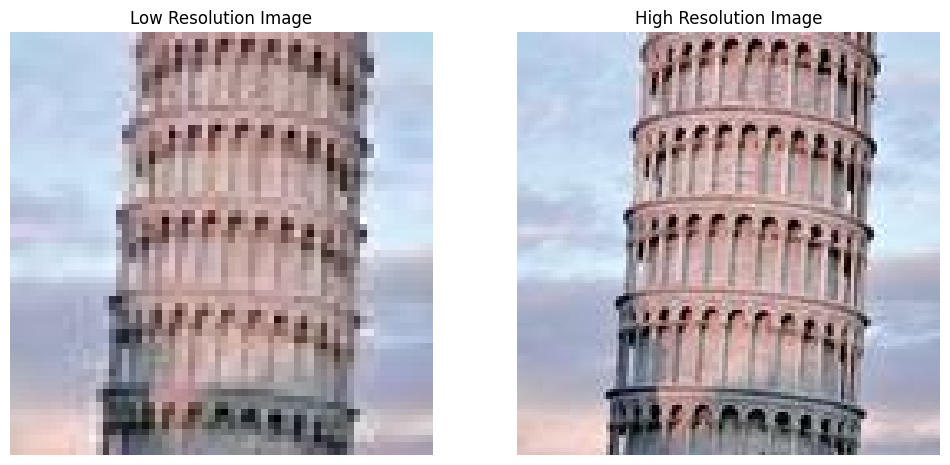

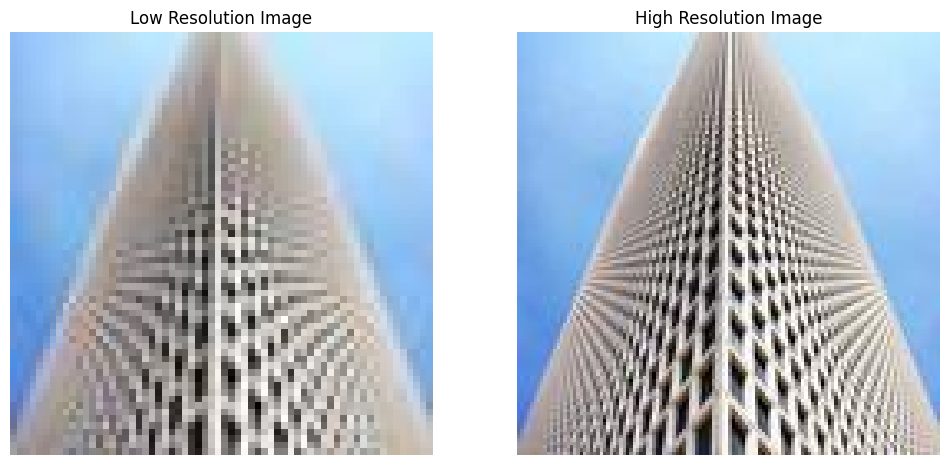

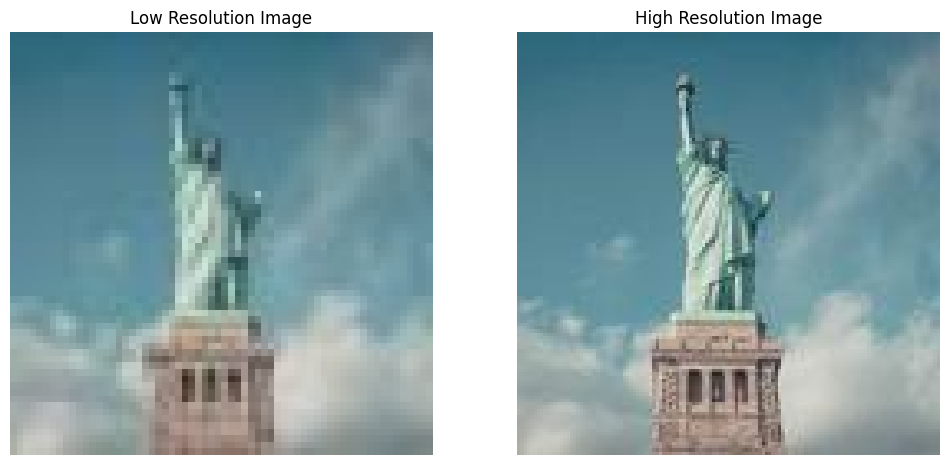

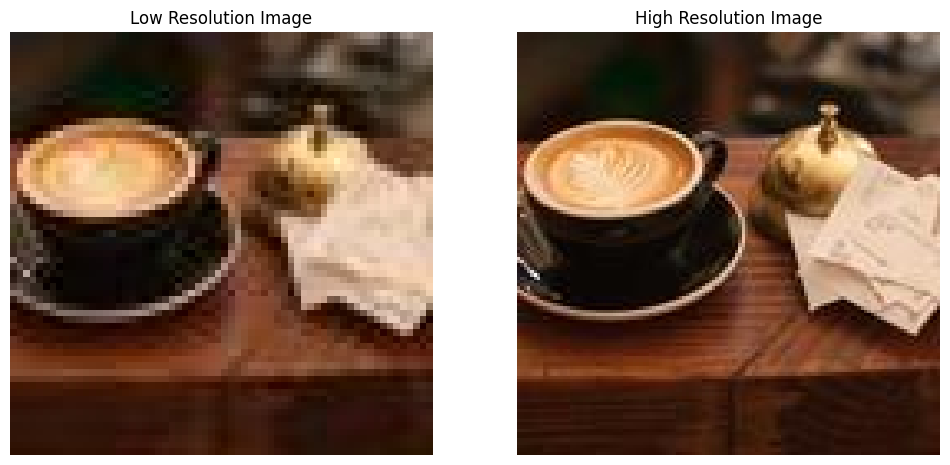

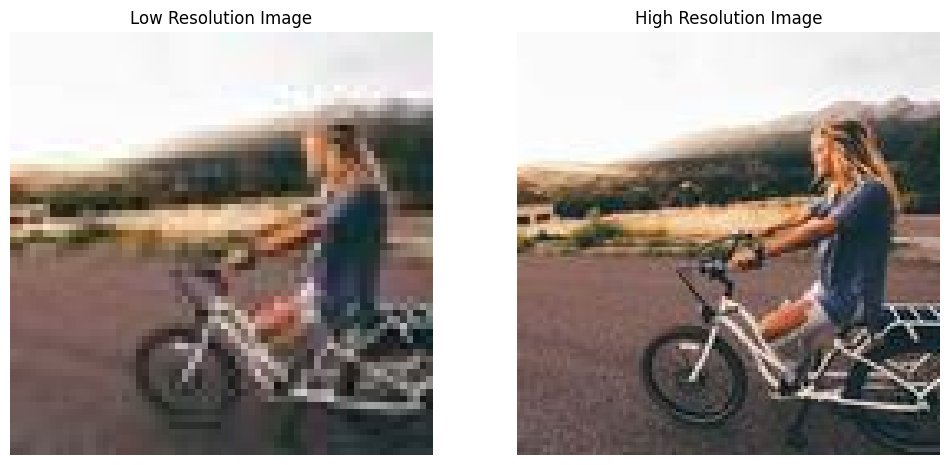

In [4]:
for lr, hr in zip(lr_images, hr_images):
    lr_image = Image.open(lr)
    hr_image = Image.open(hr)


    # Plot the images side by side
    plt.figure(figsize=(12, 6))

    # Plot Low Resolution Image
    plt.subplot(1, 2, 1)
    plt.imshow(lr_image)
    plt.title('Low Resolution Image')
    plt.axis('off')

    # Plot High Resolution Image
    plt.subplot(1, 2, 2)
    plt.imshow(hr_image)
    plt.title('High Resolution Image')
    plt.axis('off')

    plt.show()

# Inference - MaxSR-Super-Tiny

In [36]:
super_tiny_config = load_config(os.path.join(os.getcwd(), "config", "maxsr_super_tiny.yaml"))
super_tiny_config = super_tiny_config["model_config"]

# Load the pre-trained weights onto the correct device
super_tiny_model = MaxSRSuperTiny(super_tiny_config)

# Load the pre-trained weights
model_path = "/home/linuxu/Documents/models/MaxSR-super-tiny/20240820_160331/checkpoints/model-epoch-452.pth"
super_tiny_model.load_state_dict(torch.load(model_path, map_location=device))
super_tiny_model = super_tiny_model.to(device)

In [37]:
super_tiny_model.eval()

MaxSRSuperTiny(
  (sfe): ShallowFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (patch_embeddings): Linear(in_features=4096, out_features=256, bias=True)
  (positional_embedding): PositionalEmbedding()
  (stages): ModuleList(
    (0): Sequential(
      (0): AdaptiveMaxViTBlock(
        (mbconv): MBConv(
          (expand_conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
          (depthwise_conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024)
          (se_reduce): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
          (se_expand): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
          (project_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
          (norm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(1024, eps=1e

### Append PSNR SSIM results to our model

In [48]:
super_tiny_results = []
psnnr_ssim_res = []
with torch.no_grad():
    for lr, hr in zip(lr_images, hr_images):
        image = load_image(lr).to(device)
        output = super_tiny_model(image)
        hr_image = load_image(hr).to(device)
        psnr, ssim = calculate_psnr_ssim_metrics(output, hr_image, device)
        psnnr_ssim_res.append(dict(psnr=round(psnr,2), ssim=round(ssim,4)))
        st_image = tensor_to_RGB_image(output)
        super_tiny_results.append(Image.fromarray(st_image))

## save each model output to folder super-tiny

In [59]:
for i,super_tiny_output in enumerate(super_tiny_results):
    p,s = psnnr_ssim_res[i].values()
    foot = f'PSNR {p} / SSIM {s}'
    plot_image_with_footer(super_tiny_output, title='MaxSR Super-Tiny',footer=foot, output_path=f'super-tiny/{i}.png')

# ------------------------------------------------- 
<br><br>

In [44]:
img_path_for_results = '/home/linuxu/Documents/results-visual/super-tiny'

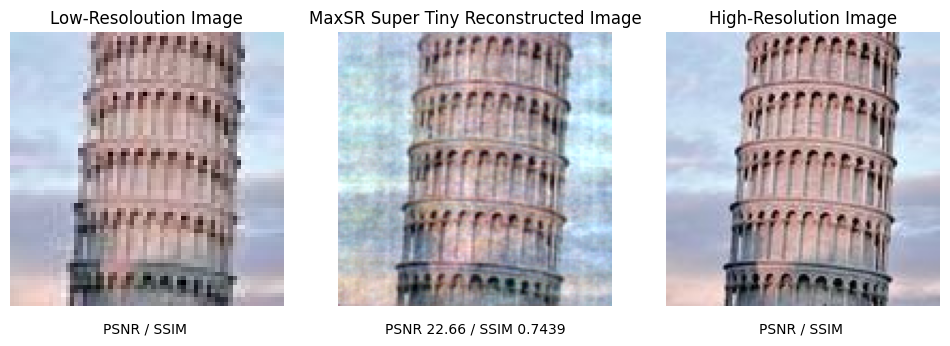

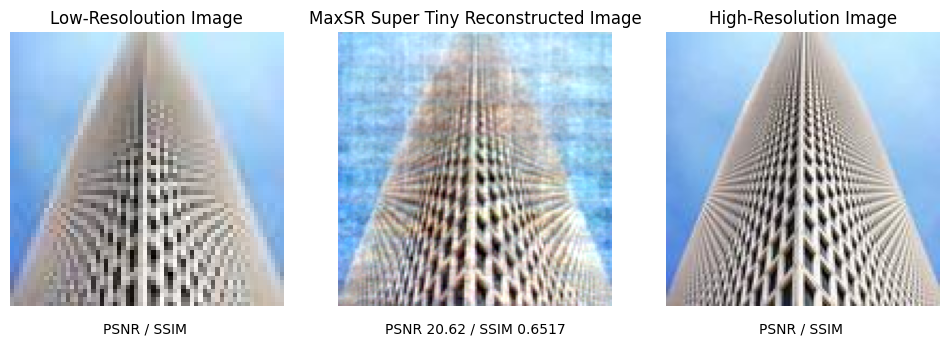

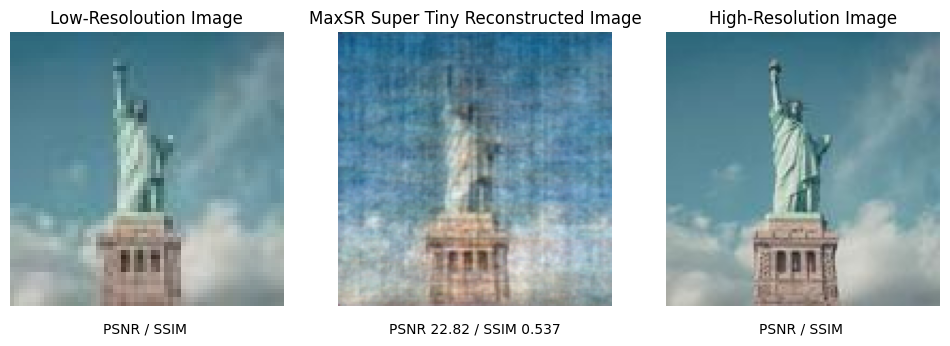

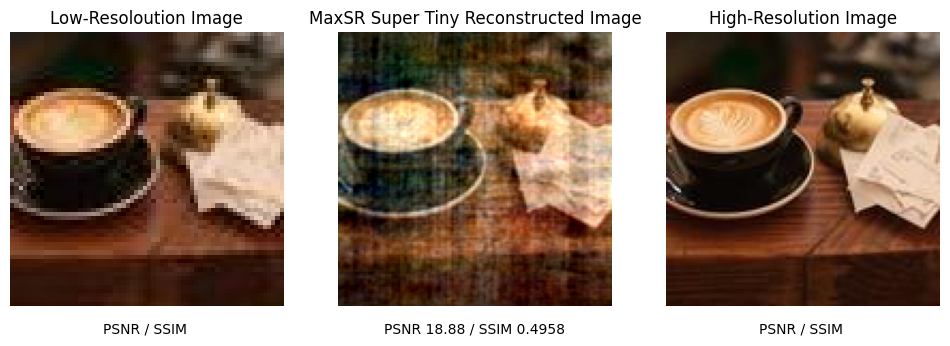

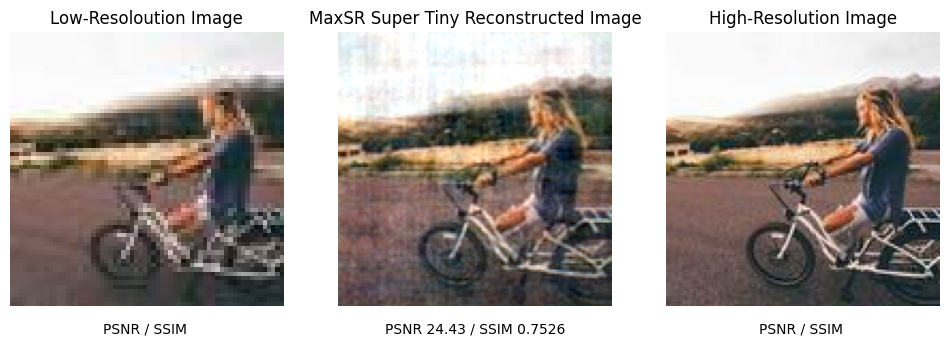

In [55]:
i = 0
for lr, reconstructed_super_tiny_image, hr in zip(lr_images, super_tiny_results, hr_images):
    
    hr_image = Image.open(hr)
    lr_image = Image.open(lr)
    p,s = psnnr_ssim_res[i].values()
    i += 1
    
    # Plot the images side by side
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # Plot Reconstructed Image
    axs[0] = plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low-Resoloution Image')
    plt.text(0.5, -0.1, f'PSNR / SSIM ', ha='center', fontsize=10, transform=axs[0].transAxes)
    plt.axis('off')

    # Plot Reconstructed Image
    axs[1] = plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_super_tiny_image)
    plt.title('MaxSR Super Tiny Reconstructed Image')
    plt.text(0.5, -0.1, f'PSNR {p} / SSIM {s}', ha='center', fontsize=10, transform=axs[1].transAxes)
    plt.axis('off')

    # Plot High-Resolution Image
    axs[2] = plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title('High-Resolution Image')
    plt.text(0.5, -0.1, f'PSNR / SSIM ', ha='center', fontsize=10, transform=axs[2].transAxes)
    plt.axis('off')

    # Show the plot
    plt.savefig(f'{img_path_for_results}/{i}.png', dpi=300, bbox_inches='tight')
    plt.show()



# Inference - MaxSR-Tiny

In [54]:
tiny_config = load_config(os.path.join(os.getcwd(), "config", "maxsr_tiny.yaml"))
tiny_config = tiny_config["model_config"]

# Load the pre-trained weights onto the correct device
tiny_model = MaxSRTiny(tiny_config)

# Load the pre-trained weights
tiny_model_path = "/home/linuxu/Documents/models/MaxSR-tiny/20240820_163825/checkpoints/model-epoch-353.pth"
tiny_model.load_state_dict(torch.load(tiny_model_path, map_location=device))
tiny_model = tiny_model.to(device)

In [55]:
tiny_model.eval()

MaxSRTiny(
  (sfe): ShallowFeatureExtractor(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (patch_embeddings): Linear(in_features=4096, out_features=256, bias=True)
  (positional_embedding): PositionalEmbedding()
  (stages): ModuleList(
    (0-3): 4 x Sequential(
      (0): AdaptiveMaxViTBlock(
        (mbconv): MBConv(
          (expand_conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1))
          (depthwise_conv): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=1024)
          (se_reduce): Conv2d(1024, 64, kernel_size=(1, 1), stride=(1, 1))
          (se_expand): Conv2d(64, 1024, kernel_size=(1, 1), stride=(1, 1))
          (project_conv): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
          (norm1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (norm2): BatchNorm2d(1024, eps=1

### append metrics to Tiny

In [56]:
tiny_results = []
tiny_psnnr_ssim_res = []
with torch.no_grad():
    for lr, hr in zip(lr_images, hr_images):
        image = load_image(lr).to(device)
        output = tiny_model(image)
        hr_image = load_image(hr).to(device)
        psnr, ssim = calculate_psnr_ssim_metrics(output, hr_image, device)
        tiny_psnnr_ssim_res.append(dict(psnr=round(psnr,2), ssim=round(ssim,4)))
        st_image = tensor_to_RGB_image(output)
        tiny_results.append(Image.fromarray(st_image))

## save model output to tiny folder

In [60]:
for i,tiny_output in enumerate(tiny_results):
    p,s = tiny_psnnr_ssim_res[i].values()
    foot = f'PSNR {p} / SSIM {s}'
    plot_image_with_footer(tiny_output, title='MaxSR Tiny',footer=foot, output_path=f'tiny/{i}.png')

In [50]:
tiny_img_path_for_results = '/home/linuxu/Documents/results-visual/tiny'

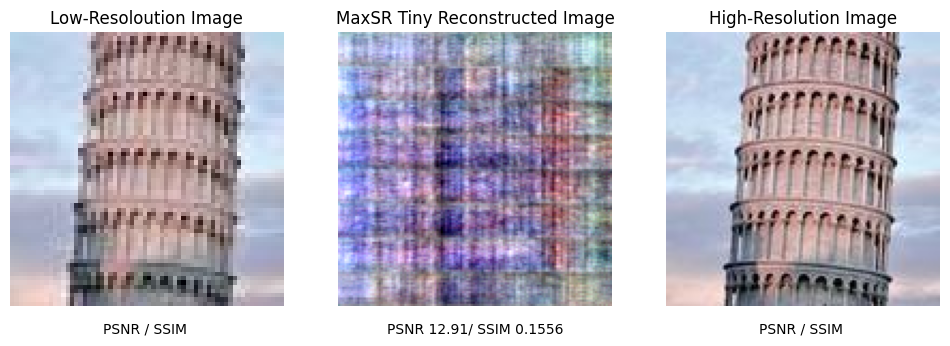

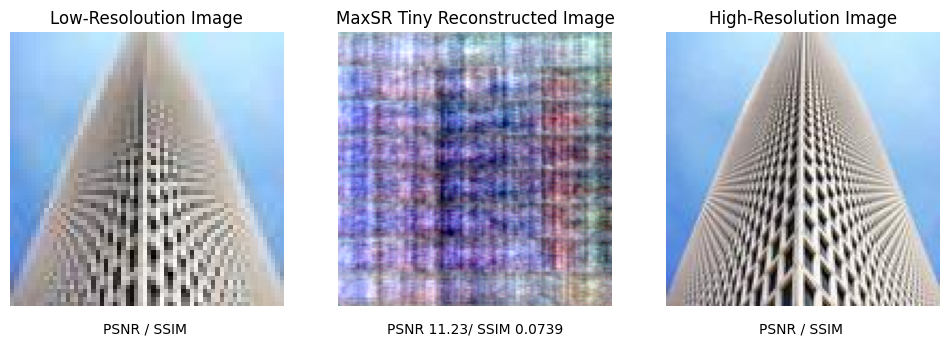

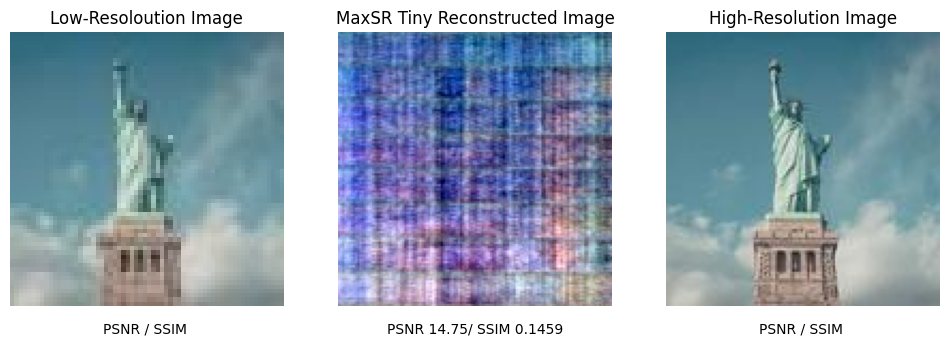

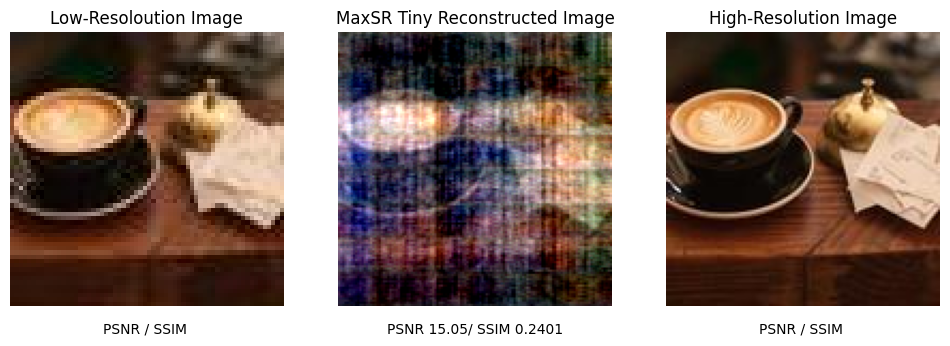

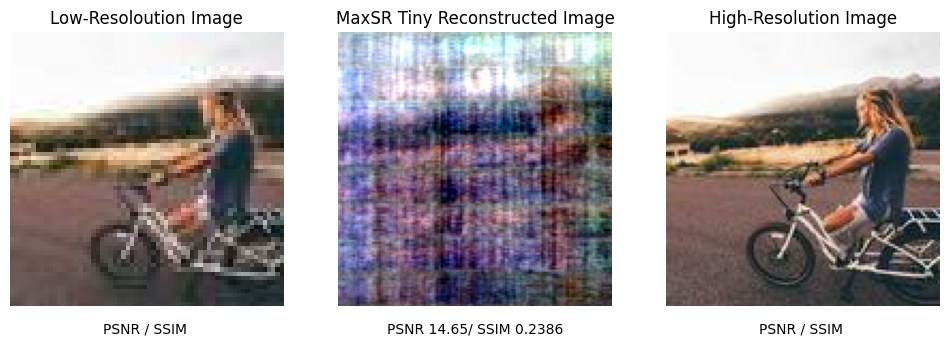

In [54]:
i = 0
for lr, reconstructed_tiny_image, hr in zip(lr_images, tiny_results, hr_images):
    
    hr_image = Image.open(hr)
    lr_image = Image.open(lr)
    p,s = tiny_psnnr_ssim_res[i].values()
    i += 1
    
    # Plot the images side by side
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    

    # Plot Reconstructed Image
    axs[0] = plt.subplot(1, 3, 1)
    plt.imshow(lr_image)
    plt.title('Low-Resoloution Image')
    plt.text(0.5, -0.1, f'PSNR / SSIM ', ha='center', fontsize=10, transform=axs[0].transAxes)
    plt.axis('off')

    # Plot Reconstructed Image
    axs[1] = plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_tiny_image)
    plt.title('MaxSR Tiny Reconstructed Image')
    plt.text(0.5, -0.1, f'PSNR {p}/ SSIM {s}', ha='center', fontsize=10, transform=axs[1].transAxes)
    plt.axis('off')

    # Plot High-Resolution Image
    axs[2] = plt.subplot(1, 3, 3)
    plt.imshow(hr_image)
    plt.title('High-Resolution Image')
    plt.text(0.5, -0.1, f'PSNR / SSIM ', ha='center', fontsize=10, transform=axs[2].transAxes)
    plt.axis('off')

    # Show the plot
    plt.savefig(f'{tiny_img_path_for_results}/{i}.png', dpi=300, bbox_inches='tight')
    plt.show()


# All models side by side

In [62]:
all_models_path = '/home/linuxu/Documents/results-visual/side-by-side'

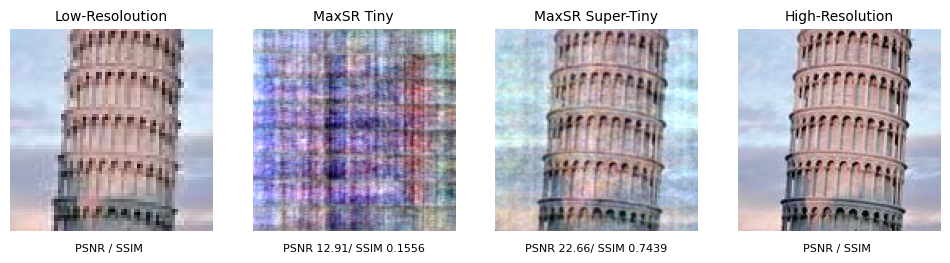

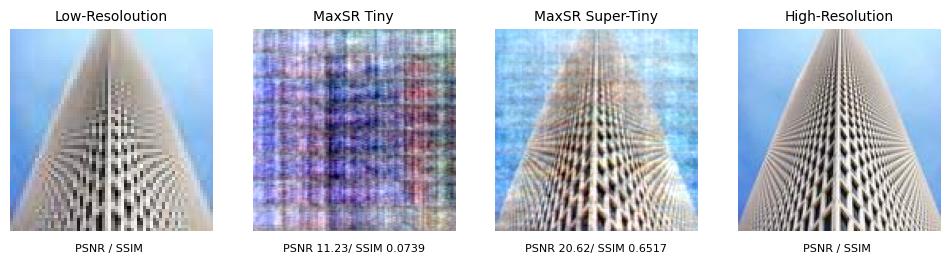

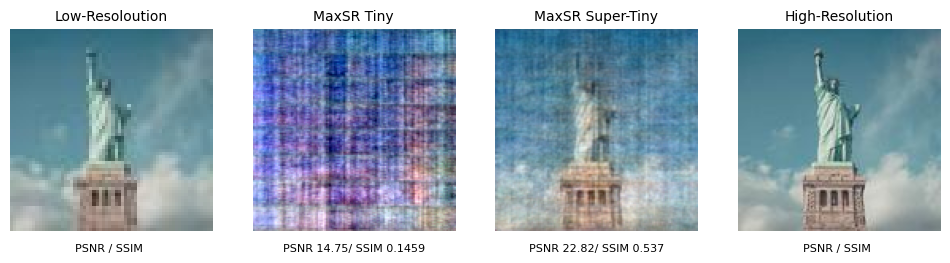

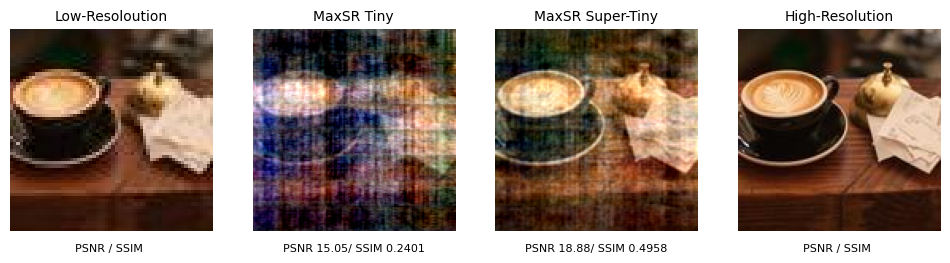

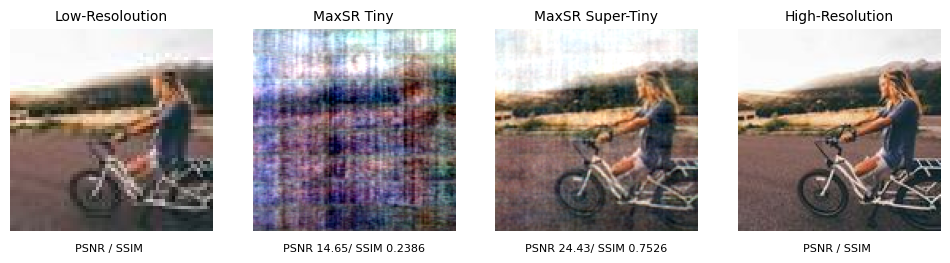

In [63]:
i = 0
for lr, reconstructed_tiny_image, reconstructed_super_tiny_image, hr in zip(lr_images, tiny_results, super_tiny_results ,hr_images):
    
    hr_image = Image.open(hr)
    lr_image = Image.open(lr)
    p,s = tiny_psnnr_ssim_res[i].values()
    p1, s1 = psnnr_ssim_res[i].values()
    i += 1
    
    # Plot the images side by side
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    

    # Plot Reconstructed Image
    axs[0] = plt.subplot(1, 4, 1)
    plt.imshow(lr_image)
    plt.title('Low-Resoloution', fontsize=10)
    plt.text(0.5, -0.1, f'PSNR / SSIM ', ha='center', fontsize=8, transform=axs[0].transAxes)
    plt.axis('off')

    # Plot Reconstructed Image Tiny
    axs[1] = plt.subplot(1, 4, 2)
    plt.imshow(reconstructed_tiny_image)
    plt.title('MaxSR Tiny', fontsize=10)
    plt.text(0.5, -0.1, f'PSNR {p}/ SSIM {s}', ha='center', fontsize=8, transform=axs[1].transAxes)
    plt.axis('off')

    # Plot Reconstructed Image Super Tiny
    axs[2] = plt.subplot(1, 4, 3)
    plt.imshow(reconstructed_super_tiny_image)
    plt.title('MaxSR Super-Tiny', fontsize=10)
    plt.text(0.5, -0.1, f'PSNR {p1}/ SSIM {s1}', ha='center', fontsize=8, transform=axs[2].transAxes)
    plt.axis('off')

    # Plot High-Resolution Image
    axs[3] = plt.subplot(1, 4, 4)
    plt.imshow(hr_image)
    plt.title('High-Resolution', fontsize=10)
    plt.text(0.5, -0.1, f'PSNR / SSIM ', ha='center', fontsize=8, transform=axs[3].transAxes)
    plt.axis('off')

    plt.savefig(f'{all_models_path}/{i}.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()
